In [308]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import utils_for_feature_engineering
from utils_for_feature_engineering import *
from catboost import CatBoostClassifier
import warnings
import importlib

warnings.simplefilter(action="ignore")

# Explanatory Data Analysis

### Big Picture

In [309]:
df = pd.read_csv("./datasets/Telco-Customer-Churn.csv")

importlib.reload(utils_for_feature_engineering)

# check_df(df)

# Converting all " " values into zeros
# df.loc[(df["TotalCharges"] == " ", "TotalCharges")] = 0.0
df.loc[df["TotalCharges"] == " ", "TotalCharges"] = df.loc[df["TotalCharges"] != " ", "TotalCharges"].astype(float).median()
# len(df.loc[(df["TotalCharges"] == " "), "TotalCharges"])
df['TotalCharges'] = df["TotalCharges"].astype(np.float64)

check_df(df)


##################### Shape #####################
(7043, 21)
##################### Types #####################
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object
##################### Head #####################
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes  

### Numerical and Categorical Variables

In [310]:
cat_cols, num_cols, cat_but_car = grab_columns(df)
print(cat_cols,num_cols, cat_but_car)

Observations: 7043
Variables: 21
cat_cols: 18
num_cols: 2
cat_but_car: 1
num_but_cat: 0
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'] ['MonthlyCharges', 'TotalCharges'] ['customerID']


### Analysis of Categorical Variables

In [311]:
importlib.reload(utils_for_feature_engineering)
for col in cat_cols:
    cat_summary(df,col, plot=False)

        gender     Ratio
gender                  
Male      3555  50.47565
Female    3488  49.52435
##########################################
               SeniorCitizen      Ratio
SeniorCitizen                          
0                       5901  83.785319
1                       1142  16.214681
##########################################
         Partner     Ratio
Partner                   
No          3641  51.69672
Yes         3402  48.30328
##########################################
            Dependents      Ratio
Dependents                       
No                4933  70.041176
Yes               2110  29.958824
##########################################
        tenure     Ratio
tenure                  
1          613  8.703677
72         362  5.139855
2          238  3.379242
3          200  2.839699
4          176  2.498935
...        ...       ...
28          57  0.809314
39          56  0.795116
44          51  0.724123
36          50  0.709925
0           11  0.156183

### Analysis of Numerical Variables

In [312]:
for col in num_cols:
    num_summary(df, col)

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
5%         19.650000
10%        20.050000
20%        25.050000
30%        45.850000
40%        58.830000
50%        70.350000
60%        79.100000
70%        85.500000
80%        94.250000
90%       102.600000
95%       107.400000
99%       114.729000
max       118.750000
Name: MonthlyCharges, dtype: float64
count    7043.000000
mean     2281.916928
std      2265.270398
min        18.800000
5%         49.650000
10%        84.610000
20%       267.370000
30%       552.820000
40%       947.380000
50%      1397.475000
60%      2043.710000
70%      3132.750000
80%      4471.440000
90%      5973.690000
95%      6921.025000
99%      8039.256000
max      8684.800000
Name: TotalCharges, dtype: float64


### Analysis of Numerical Variables with respect to Target variable

In [313]:
importlib.reload(utils_for_feature_engineering)
for col in num_cols:
    target_summary_with_num(df,"Churn", col)

       MonthlyCharges
Churn                
No          61.265124
Yes         74.441332


       TotalCharges
Churn              
No      2552.882494
Yes     1531.796094




### Correlation Analysis

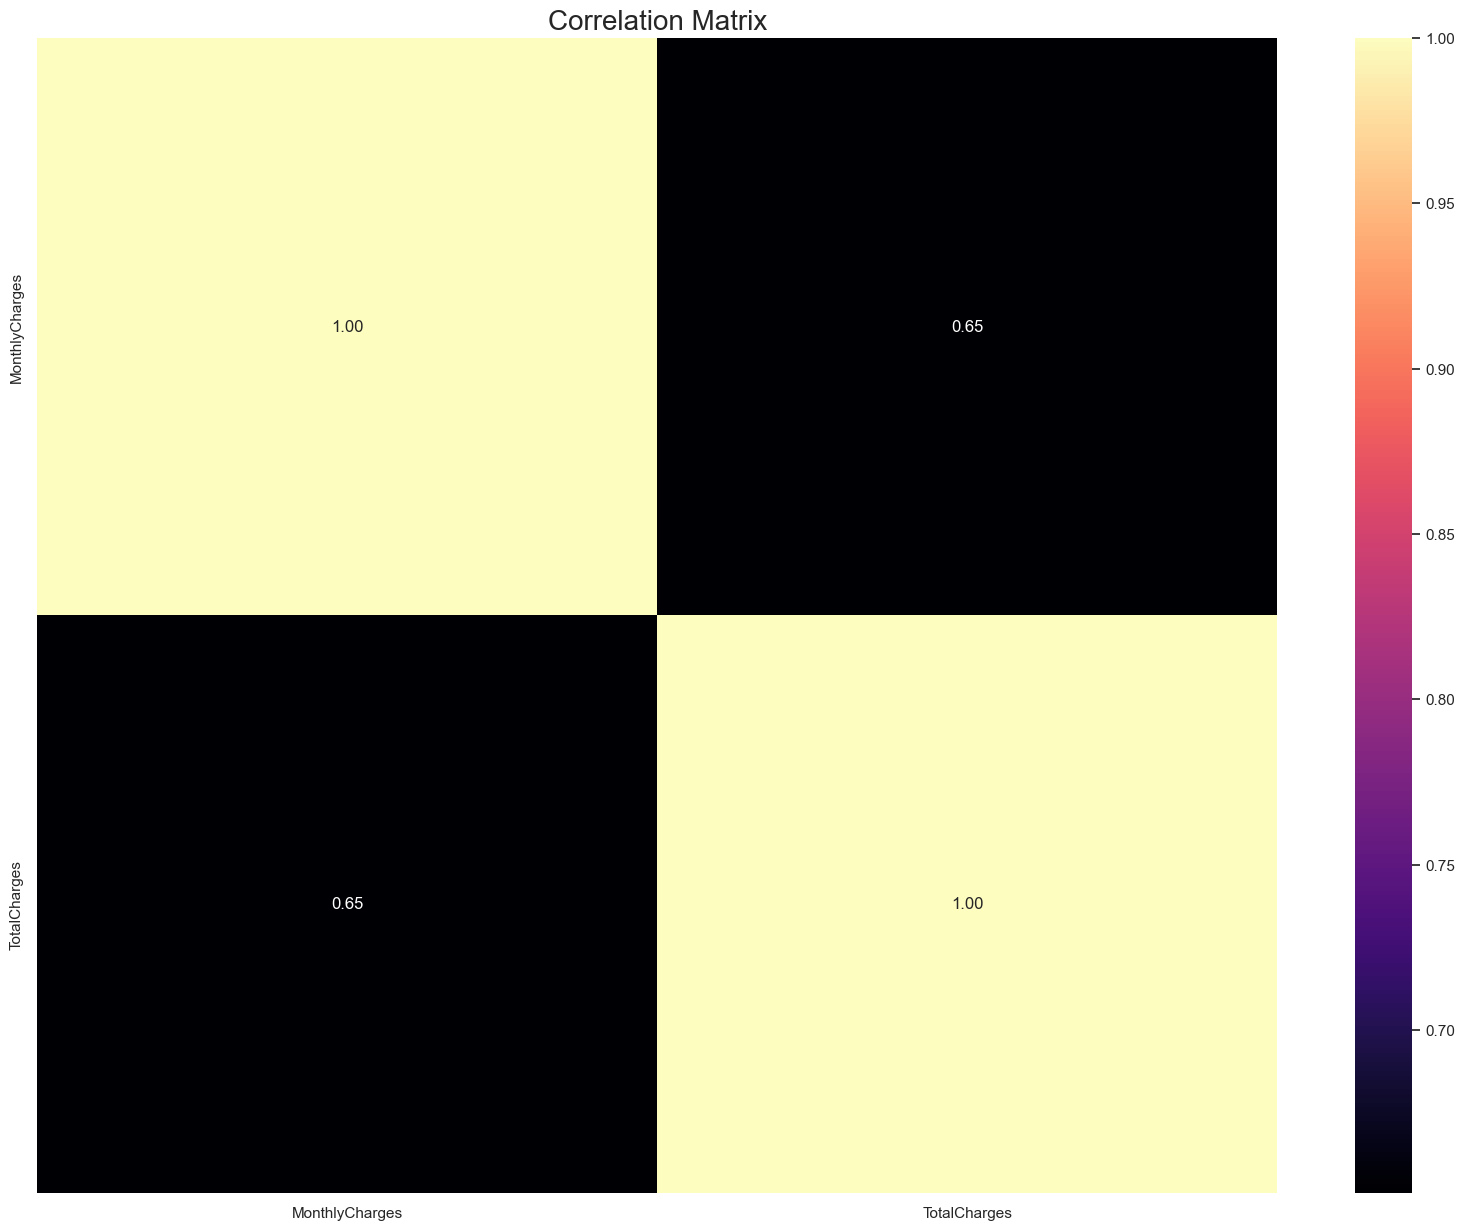

In [314]:
importlib.reload(utils_for_feature_engineering)

show_corr(df[num_cols])

### Base Model

In [315]:
temp_df = df.copy(deep=True)
temp_df.drop("customerID", axis=1, inplace=True)

temp_df["Churn"] = temp_df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)
binary_cols_temp = binary_cols(temp_df)
label_encoder_temp = LabelEncoder()


for col in binary_cols_temp:
    temp_df[col] = label_encoder_temp.fit_transform(temp_df[col])


In [316]:
cat_cols, num_cols, cat_but_car = grab_columns(temp_df)
ohe_cols = [col for col in cat_cols if col not in binary_cols_temp and col != "customerID"]
temp_df = one_hot_encoder(temp_df, ohe_cols, True)
temp_df.head()

Observations: 7043
Variables: 20
cat_cols: 18
num_cols: 2
cat_but_car: 0
num_but_cat: 5


,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,tenure_1,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,0,1,29.85,29.85,0,1,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,1,0,56.95,1889.50,0,0,...,0,0,0,0,0,1,0,0,0,1
2,1,0,0,0,1,1,53.85,108.15,1,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,42.30,1840.75,0,0,...,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,1,70.70,151.65,1,0,...,0,0,0,0,0,0,0,0,1,0


In [317]:
y = temp_df["Churn"]
X = temp_df.drop("Churn", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cb_model = CatBoostClassifier(verbose=False, random_state=42).fit(X_train, y_train)
y_pred = cb_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")



Accuracy: 0.8
Recall: 0.662
Precision: 0.52
F1: 0.58
Auc: 0.75


# Feature Engineering

### Outlier Analysis

In [318]:
missing_values_table(df,True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [319]:
for col in num_cols:
    print(grab_outliers(df,col, True))

# It seems there is no outlier in numerical columns. We can proceed to Feature Engineering Part

Empty DataFrame
Columns: [customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn]
Index: []

[0 rows x 21 columns]
Index([], dtype='int64')
Empty DataFrame
Columns: [customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn]
Index: []

[0 rows x 21 columns]
Index([], dtype='int64')


In [320]:
import sys
df["NEW_TENURE_CAT"] = pd.cut(df["tenure"], bins=[0,12,24,36,48,60,72,sys.maxsize], labels=["0-1 years", "1-2 years", "2-3 years", "3-4 years", "4-5 years", "5-6 years", "6+ years"])


In [321]:
df["NEW_noProt"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

df["NEW_AVG_Charges"] = df["TotalCharges"] / (df["tenure"] + 1)

df["NEW_AVG_CHARGE_MONTHLY_increase_rate"] = df["NEW_AVG_Charges"] / df["MonthlyCharges"]


In [322]:
df["Contract"].value_counts()

df["New_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year", "Two year"] else 0)

df["New_Engaged"].value_counts()

New_Engaged
0    3875
1    3168
Name: count, dtype: int64

In [323]:
df["No_of_Service"] =(df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']]== 'Yes').sum(axis=1)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_TENURE_CAT,NEW_noProt,NEW_AVG_Charges,NEW_AVG_CHARGE_MONTHLY_increase_rate,New_Engaged,No_of_Service
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,Electronic check,29.85,29.85,No,0-1 years,1,14.925000,0.500000,0,1
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Mailed check,56.95,1889.50,No,2-3 years,1,53.985714,0.947949,1,3
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,Mailed check,53.85,108.15,Yes,0-1 years,1,36.050000,0.669452,0,3
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Bank transfer (automatic),42.30,1840.75,No,3-4 years,1,40.016304,0.946012,1,3
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,Electronic check,70.70,151.65,Yes,0-1 years,1,50.550000,0.714993,0,1


In [324]:
df["New_Young_not_Engaged"] = df.apply(lambda x: 1 if x["New_Engaged"] == 0 and x["SeniorCitizen"] == 0 else 0, axis=1)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,MonthlyCharges,TotalCharges,Churn,NEW_TENURE_CAT,NEW_noProt,NEW_AVG_Charges,NEW_AVG_CHARGE_MONTHLY_increase_rate,New_Engaged,No_of_Service,New_Young_not_Engaged
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,29.85,29.85,No,0-1 years,1,14.925000,0.500000,0,1,1
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,56.95,1889.50,No,2-3 years,1,53.985714,0.947949,1,3,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,53.85,108.15,Yes,0-1 years,1,36.050000,0.669452,0,3,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,42.30,1840.75,No,3-4 years,1,40.016304,0.946012,1,3,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,70.70,151.65,Yes,0-1 years,1,50.550000,0.714993,0,1,1


In [325]:
df["PaymentMethod"].value_counts()
df["New_Flag_Automatic_PaymentMethod"] = df["PaymentMethod"].apply(lambda x: 1 if "automatic" in x else 0)
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TotalCharges,Churn,NEW_TENURE_CAT,NEW_noProt,NEW_AVG_Charges,NEW_AVG_CHARGE_MONTHLY_increase_rate,New_Engaged,No_of_Service,New_Young_not_Engaged,New_Flag_Automatic_PaymentMethod
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,1990.50,No,1-2 years,1,79.620000,0.938915,1,6,0,0
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,7362.90,No,5-6 years,1,100.861644,0.977342,1,5,0,1
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,346.45,No,0-1 years,1,28.870833,0.975366,0,1,1,0
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,306.60,Yes,0-1 years,1,61.320000,0.824194,0,1,0,0
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,6844.50,No,5-6 years,1,102.156716,0.966935,1,6,0,1


In [326]:
df["New_Flag_Any_Streaming"] = df.apply(lambda x: 1 if x["StreamingTV"] == "Yes" or x["StreamingMovies"] == "Yes" else 0, axis=1)
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Churn,NEW_TENURE_CAT,NEW_noProt,NEW_AVG_Charges,NEW_AVG_CHARGE_MONTHLY_increase_rate,New_Engaged,No_of_Service,New_Young_not_Engaged,New_Flag_Automatic_PaymentMethod,New_Flag_Any_Streaming
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,No,1-2 years,1,79.620000,0.938915,1,6,0,0,1
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,No,5-6 years,1,100.861644,0.977342,1,5,0,1,1
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,0-1 years,1,28.870833,0.975366,0,1,1,0,0
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,Yes,0-1 years,1,61.320000,0.824194,0,1,0,0,0
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,No,5-6 years,1,102.156716,0.966935,1,6,0,1,1


### Encoding

In [327]:
df.drop("customerID", axis=1, inplace=True) # We do not need customerID column anymore
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,Churn,NEW_TENURE_CAT,NEW_noProt,NEW_AVG_Charges,NEW_AVG_CHARGE_MONTHLY_increase_rate,New_Engaged,No_of_Service,New_Young_not_Engaged,New_Flag_Automatic_PaymentMethod,New_Flag_Any_Streaming
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,0-1 years,1,14.925000,0.500000,0,1,1,0,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,2-3 years,1,53.985714,0.947949,1,3,0,0,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,Yes,0-1 years,1,36.050000,0.669452,0,3,1,0,0
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,No,3-4 years,1,40.016304,0.946012,1,3,0,1,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,Yes,0-1 years,1,50.550000,0.714993,0,1,1,0,0


In [328]:
binary_cols = binary_cols(df)
print(binary_cols)

label_encoder(df, binary_cols)

df.head()

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn', 'NEW_noProt', 'New_Engaged', 'New_Young_not_Engaged', 'New_Flag_Automatic_PaymentMethod', 'New_Flag_Any_Streaming']


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,Churn,NEW_TENURE_CAT,NEW_noProt,NEW_AVG_Charges,NEW_AVG_CHARGE_MONTHLY_increase_rate,New_Engaged,No_of_Service,New_Young_not_Engaged,New_Flag_Automatic_PaymentMethod,New_Flag_Any_Streaming
0,0,0,1,0,1,0,No phone service,DSL,No,Yes,...,0,0-1 years,1,14.925000,0.500000,0,1,1,0,0
1,1,0,0,0,34,1,No,DSL,Yes,No,...,0,2-3 years,1,53.985714,0.947949,1,3,0,0,0
2,1,0,0,0,2,1,No,DSL,Yes,Yes,...,1,0-1 years,1,36.050000,0.669452,0,3,1,0,0
3,1,0,0,0,45,0,No phone service,DSL,Yes,No,...,0,3-4 years,1,40.016304,0.946012,1,3,0,1,0
4,0,0,0,0,2,1,No,Fiber optic,No,No,...,1,0-1 years,1,50.550000,0.714993,0,1,1,0,0


In [329]:
cat_cols, num_cols, cat_but_car = grab_columns(df)

ohe_cols = [col for col in cat_cols if col not in binary_cols and col not in ["customerID", "No_of_Service", "tenure"]]

df = one_hot_encoder(df, ohe_cols, drop_first=True)

Observations: 7043
Variables: 29
cat_cols: 25
num_cols: 4
cat_but_car: 0
num_but_cat: 6


In [330]:
check_df(df)

##################### Shape #####################
(7043, 45)
##################### Types #####################
gender                                     int32
SeniorCitizen                              int64
Partner                                    int32
Dependents                                 int32
tenure                                     int64
PhoneService                               int32
PaperlessBilling                           int32
MonthlyCharges                           float64
TotalCharges                             float64
Churn                                      int32
NEW_noProt                                 int64
NEW_AVG_Charges                          float64
NEW_AVG_CHARGE_MONTHLY_increase_rate     float64
New_Engaged                                int64
No_of_Service                              int64
New_Young_not_Engaged                      int64
New_Flag_Automatic_PaymentMethod           int64
New_Flag_Any_Streaming                     int64
Multipl

In [331]:
y = df["Churn"]
X = df.drop(["Churn"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

catboost_model = CatBoostClassifier(verbose=False, random_state=42).fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),2)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.8
Recall: 0.68
Precision: 0.51
F1: 0.58
Auc: 0.76


In [332]:
# Base Model
Accuracy: 0.8
Recall: 0.662
Precision: 0.52
F1: 0.58
Auc: 0.75

        Value                                Feature
11  11.833974   NEW_AVG_CHARGE_MONTHLY_increase_rate
4    9.825136                                 tenure
7    9.024248                         MonthlyCharges
8    8.588881                           TotalCharges
10   6.532517                        NEW_AVG_Charges
12   5.403384                            New_Engaged
19   3.948955            InternetService_Fiber optic
34   3.795374                      Contract_Two year
13   3.018984                          No_of_Service
6    2.685794                       PaperlessBilling
18   2.541766                      MultipleLines_Yes
0    2.490750                                 gender
36   2.366663         PaymentMethod_Electronic check
22   2.183151                     OnlineSecurity_Yes
3    1.593009                             Dependents
32   1.518267                    StreamingMovies_Yes
2    1.495965                                Partner
42   1.469165               NEW_TENURE_CAT_5-6

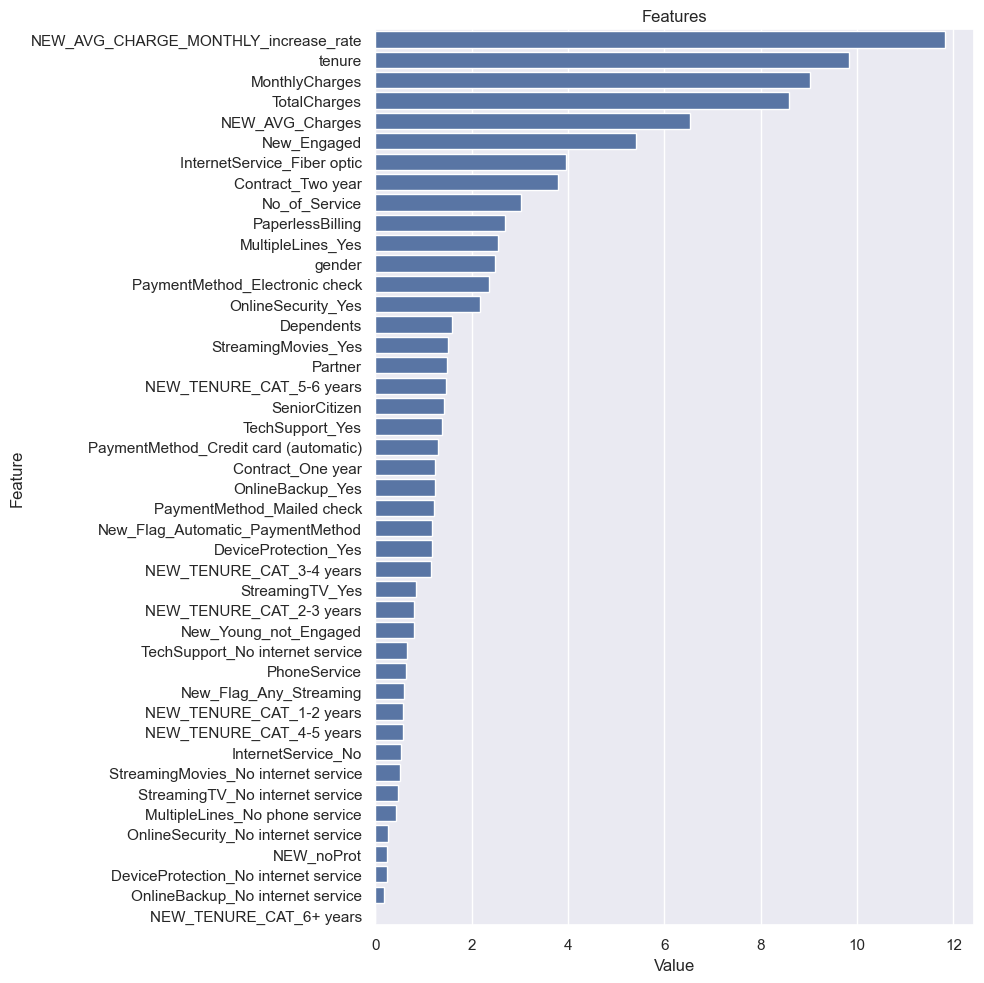

In [333]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(catboost_model, X)